## Setup

Load libraries

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pmdarima import arima
from sklearn import set_config
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import STL


set_config(
    display='diagram',
    transform_output="pandas"
)

## Load Data

Data Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

In [3]:
## create data directory

os.makedirs('./data', exist_ok=True)

## set data path
path= os.path.join('data', 'individual+household+electric+power+consumption.zip')

power_consumption_data = (
    pd.read_csv(
        filepath_or_buffer=path,
        compression='zip',
        header='infer',
        sep=';',
        na_values=['?', 'nan'],
        low_memory=False
    )
    .assign(datetime=lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time'], dayfirst=True))
    .set_index('datetime')
    .drop(columns=['Date', 'Time'])
)

power_consumption_data.info()
power_consumption_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Feature Engineering

### Explore Missing Observations

* Check Missing Observations

In [4]:
power_consumption_data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [11]:
n_missing=power_consumption_data.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {n_missing}")

Number of rows with at least one missing value: 25979


All variables have missing observations. In data analytics, there are two options for dealing with missing data:

1. We can drop all rows with at least one missing entry.
2. We can impute the mssing values - so that we do not throw away valuable instances.

Because our data is time series, dropping rows with missing entries is not feasible - it will disturb the autocorrelation between instances. There are a number of way of filling missing values for time series data:

* Last observation carried forward.
* Next observation carries backward.
* Rolling statistics (weighted moving average, weighted moving average, exponential moving average).
* K-Nearest Neighbors (KNN) imputer.
* Interpolation

For this work, we will use intepolation.

In [12]:
## fill missing observations with interpolated values

no_na_df=power_consumption_data.interpolate(method='time')

n_missing=no_na_df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value after interpolation: {n_missing}")

Number of rows with at least one missing value after interpolation: 0


### Resampling

The aim of this project is to forecast power consumption 24 hours into the future, but our data is collected every minute. We will:

1. Resample our data hourly.
2. Drop the first and last hours of data in the dataframe because they do not have up to 24 hours of data.

In [17]:
## resample data to hourly frequency

hourly_power_consumption=no_na_df.resample('h').sum()

## drop first and last hour of data
hourly_power_consumption=hourly_power_consumption.iloc[1:-1]

hourly_power_consumption.info()
hourly_power_consumption.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34587 entries, 2006-12-16 18:00:00 to 2010-11-26 20:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34587 non-null  float64
 1   Global_reactive_power  34587 non-null  float64
 2   Voltage                34587 non-null  float64
 3   Global_intensity       34587 non-null  float64
 4   Sub_metering_1         34587 non-null  float64
 5   Sub_metering_2         34587 non-null  float64
 6   Sub_metering_3         34587 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0,266.0


### Add time as Usable Features

To encode the time as a usable feature in deep learning models, the `datetime` string must be transformed to capture the cyclical nature of time. This transformation involves converting the `datetime` into a numerical value representing the number of seconds, followed by applying a sine transformation to capture the cyclical pattern of a day, bounded between -1 and 1. To distinguish between morning and afternoon, a cosine transformation is also applied, as it's out of phase with the sine function. This combined sine-cosine encoding method preserves the cyclical property of time within a day, effectively handling the inherent cyclic patterns in time series data, such as differentiating between various times of the day and maintaining the continuity and proximity between time points.

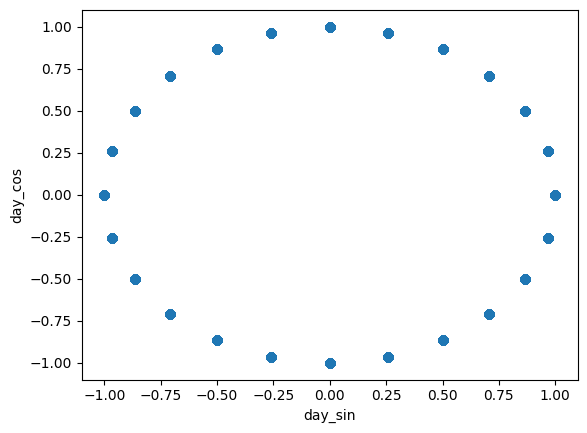

In [22]:
timestamp_s=hourly_power_consumption.index.map(lambda x: datetime.datetime.timestamp(x))

hourly_power_consumption=hourly_power_consumption.assign(
    day_sin=np.sin(timestamp_s * (2 * np.pi / (24 * 60 * 60))).values,
    day_cos=np.cos(timestamp_s * (2 * np.pi / (24 * 60 * 60))).values,
)

plt.plot(hourly_power_consumption.day_sin, hourly_power_consumption.day_cos, 'o')
plt.xlabel('day_sin')
plt.ylabel('day_cos')
plt.show()

### Descriptive Statistics

In [23]:
hourly_power_consumption.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34587.0,65.413525,53.651407,7.440000,20.572000,4.819294e+01,94.722000,393.632000
Global_reactive_power,34587.0,7.418855,4.024071,0.023918,4.676000,6.428000e+00,8.970000,46.460000
Voltage,34587.0,14449.973628,180.088322,13550.070000,14350.695000,1.445848e+04,14561.340000,15114.120000
Global_intensity,34587.0,277.274921,224.579217,30.200000,91.000000,2.054000e+02,396.200000,1703.000000
Sub_metering_1,34587.0,66.570344,211.108972,0.000000,0.000000,0.000000e+00,0.000000,2902.000000
Sub_metering_2,34587.0,77.354656,250.104691,0.000000,0.000000,2.000000e+01,39.000000,2786.000000
Sub_metering_3,34587.0,386.532845,440.447840,0.000000,39.000000,9.900000e+01,845.000000,1471.470054
day_sin,34587.0,0.000024,0.707083,-1.000000,-0.707107,-2.718614e-16,0.707107,1.000000
day_cos,34587.0,0.000049,0.707151,-1.000000,-0.707107,7.697669e-16,0.707107,1.000000


## Data Splitting

* train: 70\%
* validation: 10\%
* test: 20\%

In [25]:
n=hourly_power_consumption.shape[0] # number of rows (sample size)

train=hourly_power_consumption.iloc[:int(n*0.80)]
test=hourly_power_consumption.iloc[int(n*0.80):]

## Time Series Plot

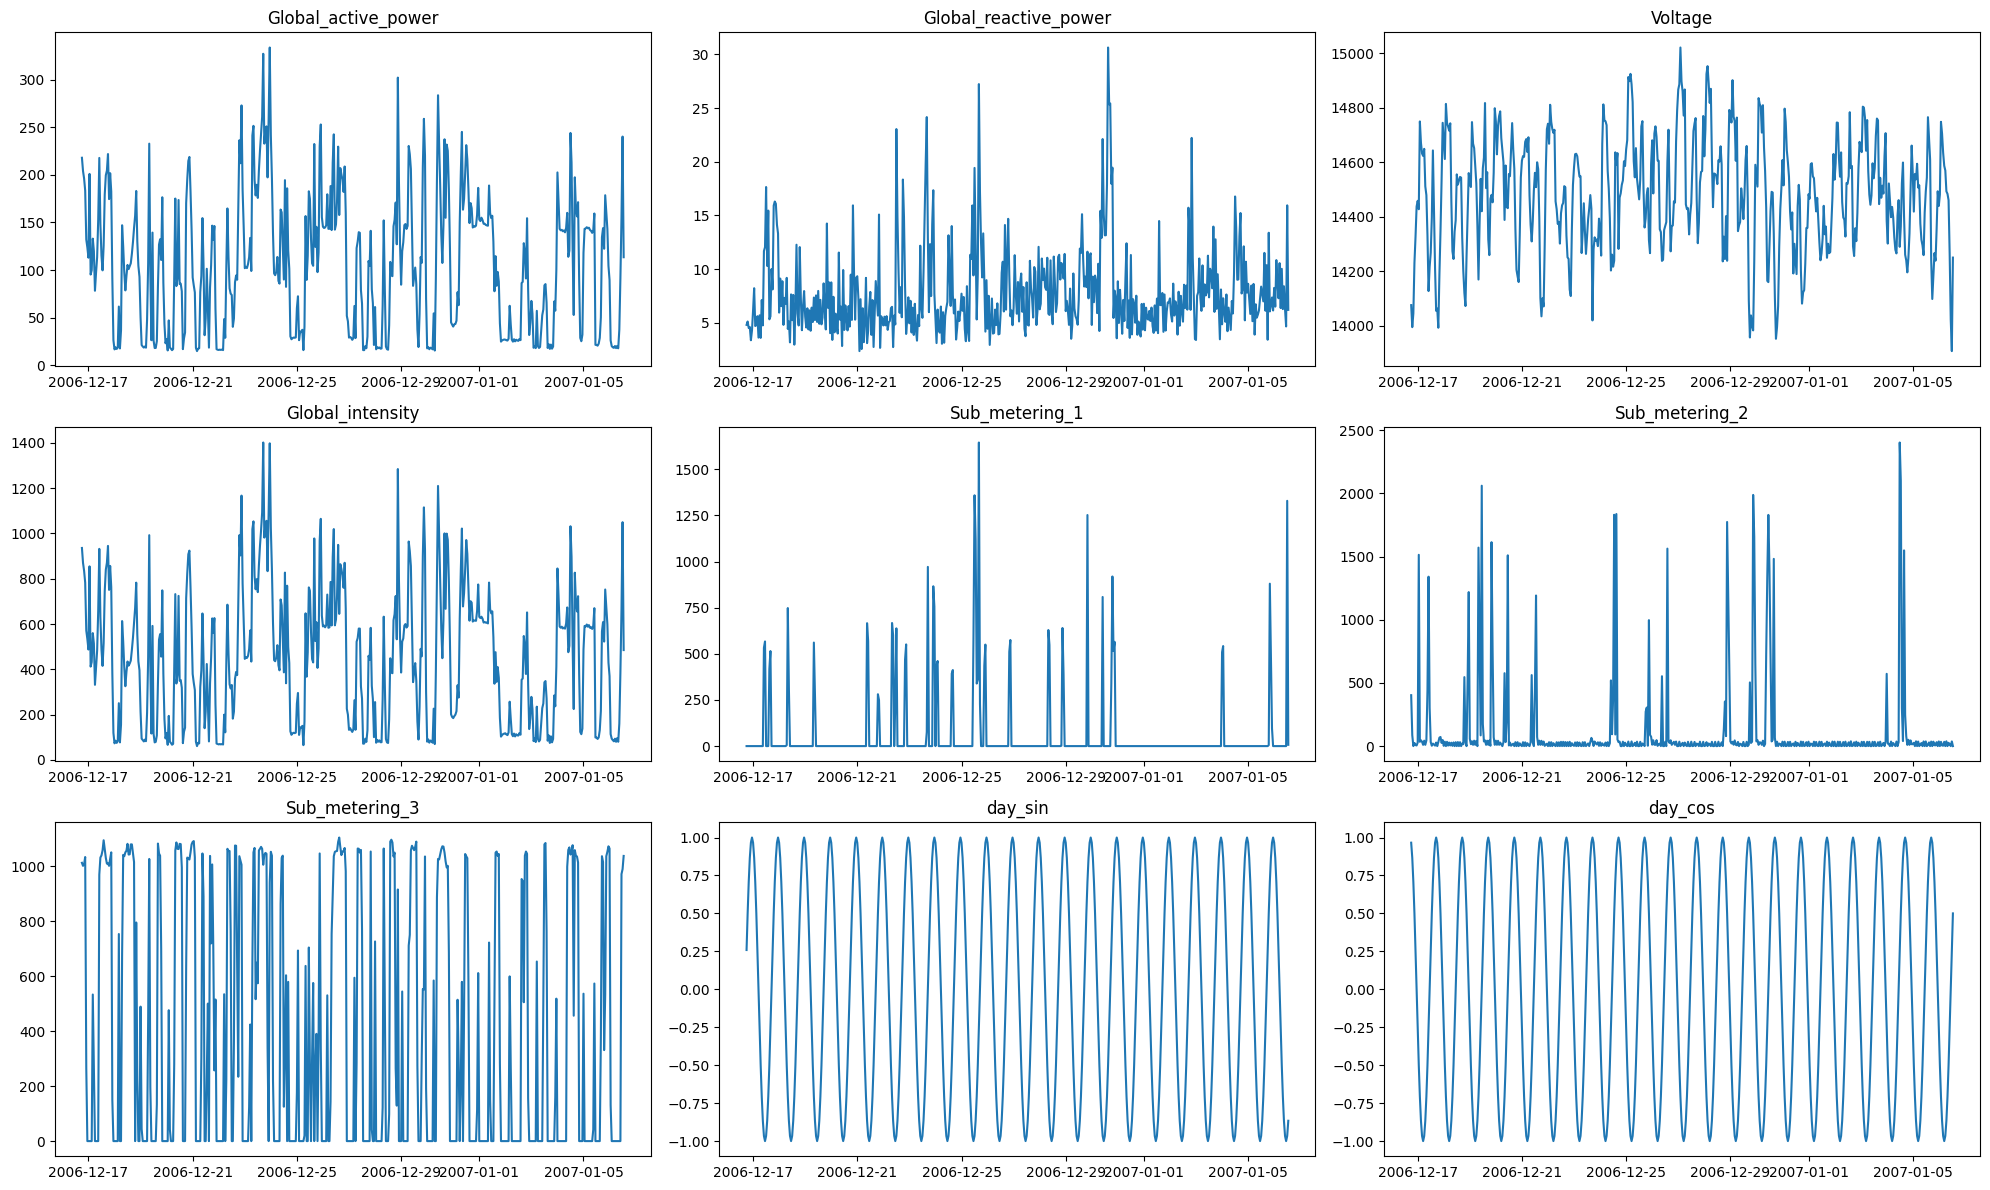

In [28]:
## time series plot of all variables (first 2000 observations)

plt.figure(figsize=(20,12))

for i, col in enumerate(train.columns):
    plt.subplot(3, 3, i+1)
    plt.plot(train[col].iloc[:500])

    plt.title(col)

plt.tight_layout()
plt.show()